** Some helpful links for learning about the basics of random projection and J-L lemma **

#### J-L Lemma
* This blog post http://www.johnmyleswhite.com/notebook/2014/03/24/a-note-on-the-johnson-lindenstrauss-lemma/ is a good start for learning about J-L lemma and random projection. DO READ IT.

#### Random Projection
* This paper http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.76.8124&rep=rep1&type=pdf gives a thorough introduction of random projection and its experimental performance.

#### Working with RP in sklearn
* Random projection: http://scikit-learn.org/stable/modules/random_projection.html
* J-L lemma: http://scikit-learn.org/stable/auto_examples/plot_johnson_lindenstrauss_bound.html

In [60]:
import numpy as np
from sklearn import random_projection
from sklearn.random_projection import johnson_lindenstrauss_min_dim
from sklearn.metrics.pairwise import euclidean_distances

# Using sklearn for Random Projection
The following few blocks demonstrate how we can perform random projection using sklearn. 

In [61]:
# the min dimension that guarantees the specific epsilon, determined by J-L Lemma
k_min = johnson_lindenstrauss_min_dim(n_samples=1e3, eps=0.2)
k_min

1594

In [62]:
# Examplar data before random projection
X = np.random.rand(1000, 10000) # the first dim is number of samples, second is original number of features

In [63]:
RP = random_projection.GaussianRandomProjection(n_components=k_min, eps=0.2)

In [64]:
# Result after random projection
X_new = RP.fit_transform(X)
X_new.shape

(1000, 1594)

In [65]:
SRP = random_projection.SparseRandomProjection(n_components=k_min, eps=0.2)

In [66]:
# Result after sparse random projection
X_new = SRP.fit_transform(X)
X_new.shape

(1000, 1594)

# Using RP on Text Data

In [67]:
from sklearn.datasets import fetch_20newsgroups_vectorized
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from time import time
from sklearn.random_projection import SparseRandomProjection

In [68]:
data = fetch_20newsgroups_vectorized().data[:500]

In [69]:
n_samples, n_features = data.shape
print("Embedding %d samples with dim %d using various random projections"
      % (n_samples, n_features))

n_components_range = np.array([1000, 2000]) # can try with 300, 1000, 10000
dists = euclidean_distances(data, squared=True).ravel()

# select only non-identical samples pairs
nonzero = dists != 0
dists = dists[nonzero]

Embedding 500 samples with dim 130107 using various random projections


In [70]:
k_min = johnson_lindenstrauss_min_dim(n_samples=n_features, eps=0.2)
print("Require %d dimensions after projection according to J-L lemma"
      % (k_min))

Require 2717 dimensions after projection according to J-L lemma


Projected 500 samples from 130107 to 1000 in 0.614s
Random matrix with size: 4.321MB
Mean distances rate: 0.93 (0.10)
Projected 500 samples from 130107 to 2000 in 1.209s
Random matrix with size: 8.652MB
Mean distances rate: 0.98 (0.07)


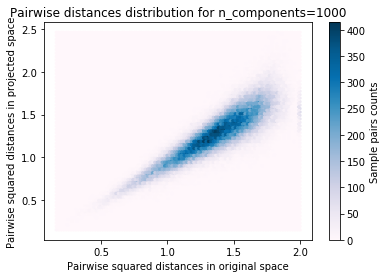

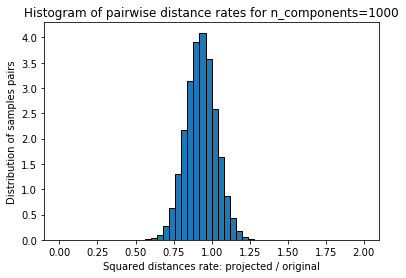

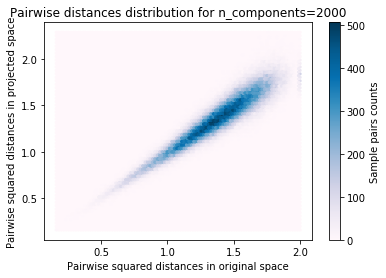

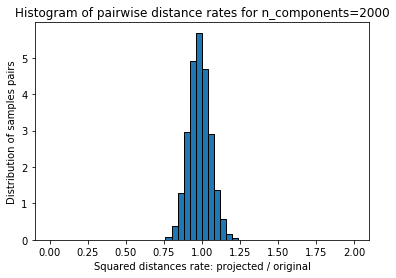

In [71]:
for n_components in n_components_range:
    t0 = time()
    rp = SparseRandomProjection(n_components=n_components)
    projected_data = rp.fit_transform(data)
    print("Projected %d samples from %d to %d in %0.3fs"
          % (n_samples, n_features, n_components, time() - t0))
    if hasattr(rp, 'components_'):
        n_bytes = rp.components_.data.nbytes
        n_bytes += rp.components_.indices.nbytes
        print("Random matrix with size: %0.3fMB" % (n_bytes / 1e6))

    projected_dists = euclidean_distances(
        projected_data, squared=True).ravel()[nonzero]

    plt.figure()
    plt.hexbin(dists, projected_dists, gridsize=100, cmap=plt.cm.PuBu)
    plt.xlabel("Pairwise squared distances in original space")
    plt.ylabel("Pairwise squared distances in projected space")
    plt.title("Pairwise distances distribution for n_components=%d" %
              n_components)
    cb = plt.colorbar()
    cb.set_label('Sample pairs counts')

    rates = projected_dists / dists
    print("Mean distances rate: %0.2f (%0.2f)"
          % (np.mean(rates), np.std(rates)))

    plt.figure()
    plt.hist(rates, bins=50, normed=True, range=(0., 2.), edgecolor='k')
    plt.xlabel("Squared distances rate: projected / original")
    plt.ylabel("Distribution of samples pairs")
    plt.title("Histogram of pairwise distance rates for n_components=%d" %
              n_components)

plt.show()

# Using RP on Image Data

In [72]:
# TODO: find some image dataset, better with label,
# so that it can be used both for clustering and kNN.
# Surveillance camera data can be a fit.

# Clustering and kNN on Text Data

In [73]:
# TODO: perform clustering and kNN on our text dataset
# compare **performance** and **time complexity** before
# and after random projection.

# Clustering and kNN on Image Data

In [74]:
# TODO: perform clustering and kNN on our image dataset
# compare **performance** and **time complexity** before
# and after random projection.